In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

In [4]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
base_path = "/content/drive/My Drive/balls-image-classification/balls"

train_dir = "/content/drive/My Drive/balls-image-classification/balls/train"
test_dir = "/content/drive/My Drive/balls-image-classification/balls/test"
val_dir = "/content/drive/My Drive/balls-image-classification/balls/valid"

In [6]:
df = pd.read_csv("/content/drive/My Drive/balls-image-classification/balls/balls.csv")

In [7]:
print(f"Total number of imgaes -- > {len(df)}")

Total number of imgaes -- > 3100


In [8]:
data_count = df['data set'].value_counts()

In [9]:
print(f"Number of training images --> {data_count[0]}")
print(f"Number of testing images --> {data_count[1]}")
print(f"Number of validation images --> {data_count[2]}")

Number of training images --> 2860
Number of testing images --> 120
Number of validation images --> 120


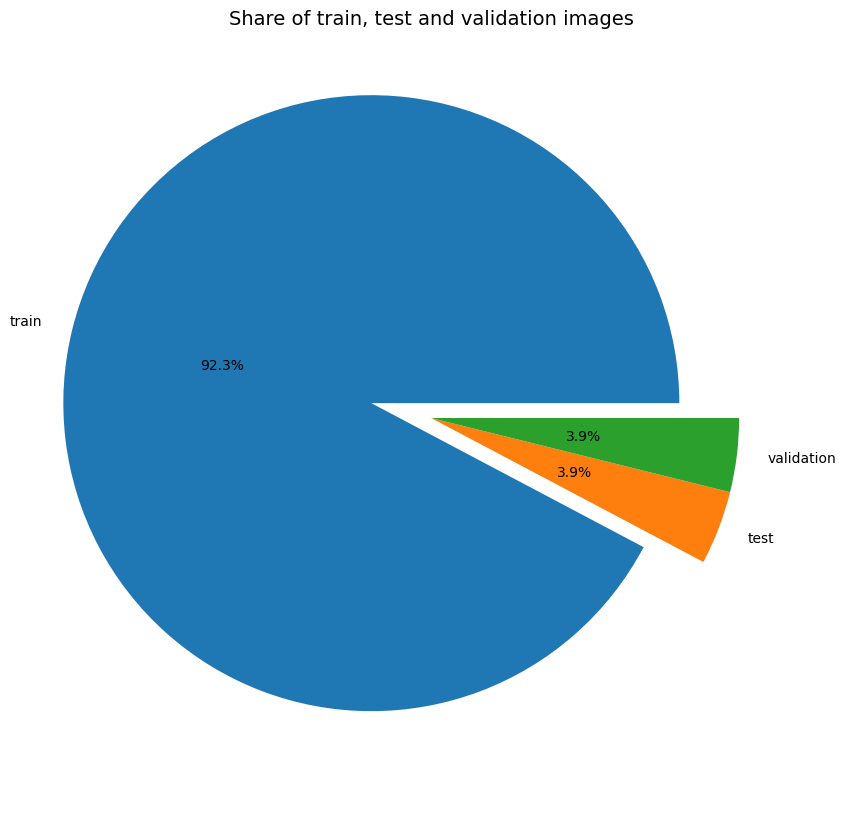

In [10]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([data_count[0], data_count[1], data_count[2]]), autopct="%.1f%%", explode=[0.2,0, 0], labels=["train", "test", "validation"], pctdistance=0.5)
plt.title("Share of train, test and validation images", fontsize=14);

In [11]:
ball_classes = os.listdir(train_dir)

In [12]:
len(ball_classes)

24

In [13]:
train_images = glob.glob(f"{train_dir}/*/*.jpg")
test_images = glob.glob(f"{test_dir}/*/*.jpg")
val_images = glob.glob(f"{val_dir}/*/*.jpg")

In [14]:
class_dict = {}
for clas in ball_classes:
    num_items = len(os.listdir(os.path.join(train_dir, clas)))
    class_dict[clas] = num_items

In [15]:
class_dict

{'baseball': 112,
 'basketball': 116,
 'beachballs': 92,
 'billiard ball': 143,
 'bowling ball': 145,
 'golf ball': 106,
 'football': 112,
 'eyeballs': 139,
 'brass': 113,
 'marble': 131,
 'cricket ball': 150,
 'buckeyballs': 82,
 'meat ball': 137,
 'cannon ball': 183,
 'medicine ball': 77,
 'wiffle ball': 99,
 'wrecking ball': 69,
 'puffballs': 106,
 'volley ball': 131,
 'screwballs': 140,
 'paint balls': 32,
 'water polo ball': 139,
 'tennis ball': 139,
 'soccer ball': 167}

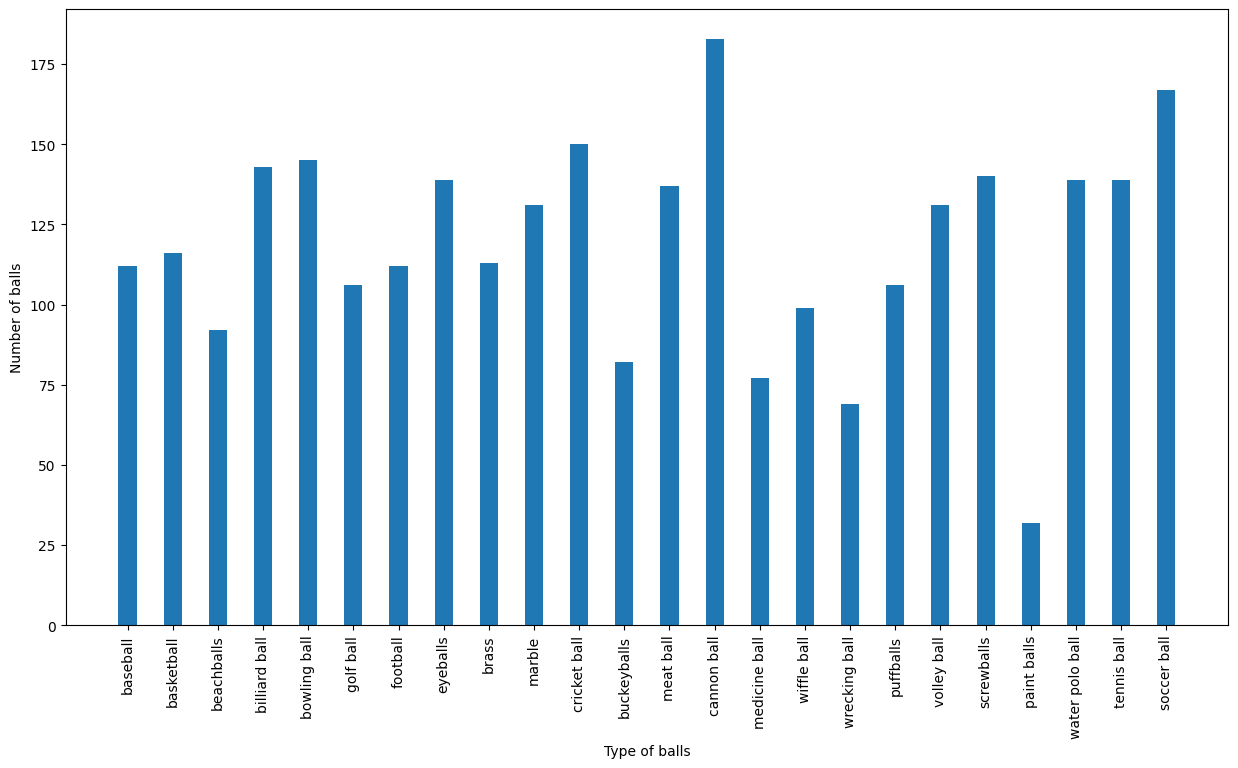

In [16]:
plt.figure(figsize=(15,8))
plt.bar(list(class_dict.keys()), list(class_dict.values()), width=0.4,align="center" )
plt.xticks(rotation=90)

plt.xlabel("Type of balls")
plt.ylabel("Number of balls")
plt.show()

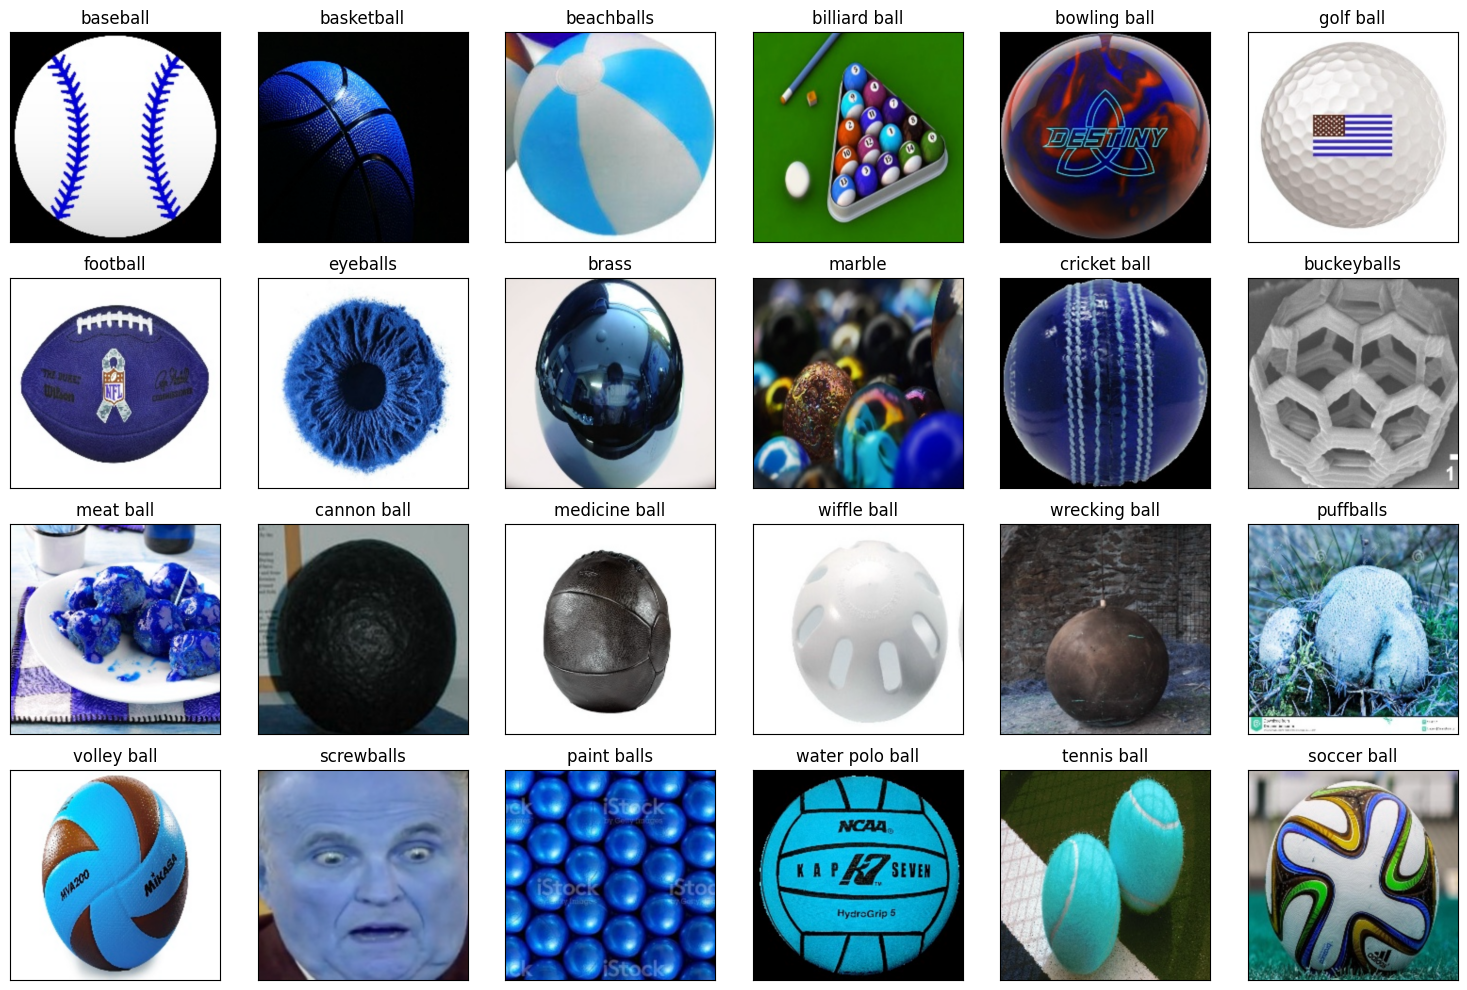

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    images = os.listdir(os.path.join(train_dir, ball_classes[i]))
    img = cv2.imread(os.path.join(train_dir, ball_classes[i], images[i]))
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title(ball_classes[i])
fig.tight_layout()
plt.show()

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='categorical', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=32, class_mode = 'categorical', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(test_dir,shuffle=False, batch_size=32, class_mode = 'categorical', target_size=(220, 220))

Found 2860 images belonging to 24 classes.
Found 120 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


In [19]:
input_shape = (220, 220, 3)

In [20]:
# define the model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='softmax'))
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                           

In [21]:
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

# callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 30, epochs=50)

Epoch 1/50
30/30 [==============================] - 297s 10s/step - loss: 1.5235 - accuracy: 0.6032 - val_loss: 1.1027 - val_accuracy: 0.7167
Epoch 2/50
30/30 [==============================] - 183s 6s/step - loss: 0.5885 - accuracy: 0.8372 - val_loss: 0.5013 - val_accuracy: 0.8417
Epoch 3/50
30/30 [==============================] - 135s 4s/step - loss: 0.4417 - accuracy: 0.8667 - val_loss: 0.3236 - val_accuracy: 0.9167
Epoch 4/50
30/30 [==============================] - 104s 3s/step - loss: 0.2803 - accuracy: 0.9094 - val_loss: 0.3880 - val_accuracy: 0.8917
Epoch 5/50
30/30 [==============================] - 78s 3s/step - loss: 0.2580 - accuracy: 0.9146 - val_loss: 0.2131 - val_accuracy: 0.9333
Epoch 6/50
30/30 [==============================] - 70s 2s/step - loss: 0.2339 - accuracy: 0.9287 - val_loss: 0.3702 - val_accuracy: 0.8833
Epoch 7/50
30/30 [==============================] - 63s 2s/step - loss: 0.1851 - accuracy: 0.9394 - val_loss: 0.2612 - val_accuracy: 0.9083
Epoch 8/50
30/3

In [22]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

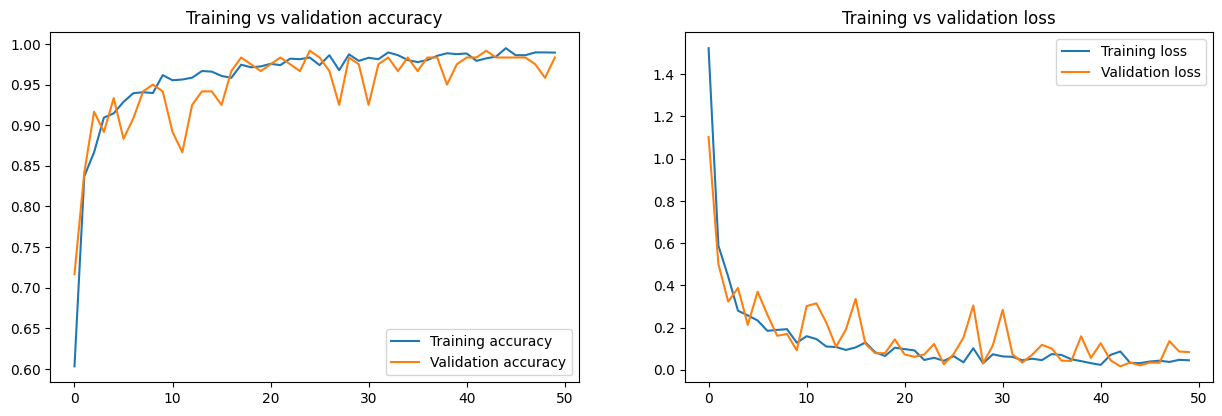

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [24]:
pred = model.predict(test_generator)

4/4 [==============================] - 26s 7s/step


In [25]:
pred

array([[9.9999982e-01, 2.7071199e-12, 2.7180635e-15, ..., 3.9772407e-15,
        1.0361995e-09, 1.1888963e-10],
       [9.9999934e-01, 5.5187865e-11, 2.4648474e-14, ..., 1.6962941e-14,
        1.0308194e-09, 2.8357838e-10],
       [9.9999994e-01, 2.6065941e-14, 2.6099355e-19, ..., 5.3265514e-20,
        2.3974228e-13, 2.0840220e-13],
       ...,
       [7.2878335e-14, 1.2649470e-07, 2.3189143e-14, ..., 2.4066404e-13,
        1.5133316e-16, 9.9999982e-01],
       [5.2057286e-12, 8.7093264e-07, 3.9795372e-11, ..., 8.6483508e-11,
        2.1751154e-14, 9.9999887e-01],
       [1.0504358e-12, 1.0902876e-06, 1.2321029e-12, ..., 3.9948318e-12,
        1.6647384e-15, 9.9999779e-01]], dtype=float32)

In [26]:
y_pred = np.argmax(pred, axis=1)

In [27]:
y_pred_class = dict((v,k) for k,v in test_generator.class_indices.items())

In [28]:
y_pred_class

{0: 'baseball',
 1: 'basketball',
 2: 'beachballs',
 3: 'billiard ball',
 4: 'bowling ball',
 5: 'brass',
 6: 'buckeyballs',
 7: 'cannon ball',
 8: 'cricket ball',
 9: 'eyeballs',
 10: 'football',
 11: 'golf ball',
 12: 'marble',
 13: 'meat ball',
 14: 'medicine ball',
 15: 'paint balls',
 16: 'puffballs',
 17: 'screwballs',
 18: 'soccer ball',
 19: 'tennis ball',
 20: 'volley ball',
 21: 'water polo ball',
 22: 'wiffle ball',
 23: 'wrecking ball'}

In [29]:
y_pred

array([ 0,  0,  0,  0,  0,  1,  1,  1, 10,  1,  2,  2,  2,  2,  2, 20,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 23, 13,
       13, 13, 14, 14, 10, 14, 14, 19, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17,  1, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 21,
       20, 20, 20, 20, 21, 21,  1, 20, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23])

In [30]:
y_pred = list(map(lambda x: y_pred_class[x], y_pred))

In [31]:
y_pred

['baseball',
 'baseball',
 'baseball',
 'baseball',
 'baseball',
 'basketball',
 'basketball',
 'basketball',
 'football',
 'basketball',
 'beachballs',
 'beachballs',
 'beachballs',
 'beachballs',
 'beachballs',
 'volley ball',
 'billiard ball',
 'billiard ball',
 'billiard ball',
 'billiard ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'brass',
 'brass',
 'brass',
 'brass',
 'brass',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'football',
 'football',
 'football',
 'football',
 'football',
 'golf ball',
 'golf ball',
 'golf ball',
 'golf ball',
 'golf ball',
 'marble',
 'marble',
 'marble',
 'marble',
 'marble',
 'meat ball',
 'wrecking ball',
 'meat ball',
 'meat ball',
 'me

In [32]:
y_true = test_generator.classes

In [33]:
y_true = list(map(lambda x: y_pred_class[x], y_true))

In [34]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

       baseball       1.00      1.00      1.00         5
     basketball       0.67      0.80      0.73         5
     beachballs       1.00      1.00      1.00         5
  billiard ball       1.00      0.80      0.89         5
   bowling ball       1.00      1.00      1.00         5
          brass       1.00      1.00      1.00         5
    buckeyballs       1.00      1.00      1.00         5
    cannon ball       1.00      1.00      1.00         5
   cricket ball       1.00      1.00      1.00         5
       eyeballs       1.00      1.00      1.00         5
       football       0.71      1.00      0.83         5
      golf ball       1.00      1.00      1.00         5
         marble       1.00      1.00      1.00         5
      meat ball       1.00      0.80      0.89         5
  medicine ball       1.00      0.80      0.89         5
    paint balls       1.00      0.80      0.89         5
      puffballs       1.00    

In [35]:
results = model.evaluate(test_generator)

4/4 [==============================] - 6s 1s/step - loss: 0.3940 - accuracy: 0.9167
